# RoiMaker

TODO:
- ~~Pick tif code from AutoShift~~
- ~~Read and plot a huge image~~
- ~~Load model~~
- Apply model in a center-only fashion (overlapping patches retaining all but a certain margin)
- Run cv2 connectedComponents
- Filter ROIs according to size and intensity
- Get intensity of ROIs for other channels
- Plot all (3 2D scatter plot)
- Think for 2D map and spatial network

In [4]:
import sys
sys.executable

'/usr/bin/python3'

In [1]:
import cv2
import numpy as np
from PIL import Image
from scipy import ndimage
from skimage import io
import gc
import matplotlib.pyplot as plt
import sympy as sp
import configparser as conf
import tensorflow as tf
import segmentation_models as sm

%matplotlib inline
%precision 3

ModuleNotFoundError: No module named 'cv2'

In [9]:
def get_imagej_metadata(img):
    ls = [v for v in img.tag.values()]
    for element in ls:
        if type(element) is not tuple:
            continue
        if len(element) == 0:
            continue
        if type(element[0]) is not str:
            continue
        if 'ImageJ' in element[0]:
            return element[0]

def format_imagej_metadata(metadata):
    ret = {name: value for (name, value) in 
           [tuple(x.split("=")) for x in metadata.split("\n")
               if "=" in x]}
    return ret
        
def get_t(img):
    metadata = get_imagej_metadata(img)
    dict_metadata = format_imagej_metadata(metadata)
    return int(dict_metadata["frames"])
    
def get_z(img):
    metadata = get_imagej_metadata(img)
    dict_metadata = format_imagej_metadata(metadata)
    return int(dict_metadata["slices"])

def get_c(img):
    metadata = get_imagej_metadata(img)
    dict_metadata = format_imagej_metadata(metadata)
    return int(dict_metadata["channels"])

def seek_image(img, t=None, z=None, c=None):
    # if stuff for later
    img.seek(c)
    
def show(img, t=None, z=None, c=None): # take the seek, make the size bigger, handle a list of seeks in subplot
    plt.figure(figsize=(10, 10))
    seek_image(img, t=t, z=z, c=c)
    plt.imshow(img)
    plt.show()

In [62]:
# this image is a selected Z of a stacked image
imagepath = "/home/nathan/Desktop/data/immuno/RoiMaker/E80_Ki67-Tbr2-Pax6-Dapi.tif"
imagepath2 ="/home/nathan/Desktop/data/immuno/RoiMaker/serie 1-1kamella.tif"
modelpath = "/home/nathan/Desktop/data/dl_data/monitoring/generator_model_34.h5"

In [63]:
img = Image.open(imagepath)
img2 = Image.open(imagepath2)

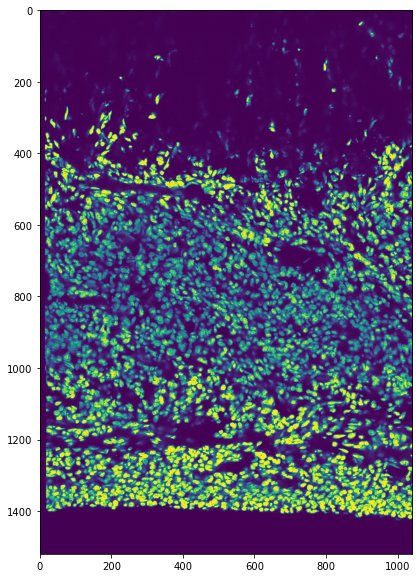

In [16]:
show(img, c=3)

In [22]:
model = sm.Unet("efficientnetb0", activation="softmax",
                input_shape=(224, 224, 3), encoder_weights='imagenet',
               classes=3)
model.load_weights(modelpath)

In [52]:
import math

def apply_patch(model, patch):
    patch = np.asarray(patch)[:, :, :3] / 255.
    pred = model.predict(np.array([patch]))[0]
    return pred

def binary_mask(patch_mask):
    patch_mask = patch_mask * np.array([1, 1, 1.5]) # increasing border
    patch_mask = np.argmax(patch_mask, axis=2)
    return patch_mask == 1

def segment_image(model, image, patch_size=(224, 224), margin=12):
    arr = np.asarray(image)
    size = arr.shape[:2]
    if arr.ndim == 2:
        arr = arr.reshape((*arr.shape, 1))
        arr = np.repeat(arr, 3, axis=-1)
        
    # this is the size of the part we keep in the prediction (the center cropped)
    kernel_patch_size = (patch_size[0] - margin * 2, patch_size[1] - margin * 2)
    
    nb_patch_x = math.ceil(size[0] / kernel_patch_size[0])
    nb_patch_y = math.ceil(size[1] / kernel_patch_size[1])
    
    kernel_size = (nb_patch_x * kernel_patch_size[0], nb_patch_y * kernel_patch_size[1])
    
    image_margin = np.zeros((
        kernel_size[0] + margin * 2,
        kernel_size[1] + margin * 2,
        3
    ))
    
    image_margin[margin:margin+arr.shape[0], margin:margin+arr.shape[1], :] = arr[:, :, :]
    mask = np.zeros(kernel_size, dtype=np.bool) # this might be biger than input image because of `ceil`
    
    for i in range(nb_patch_x):
        for j in range(nb_patch_y):
            patch = image_margin[i * kernel_patch_size[0]: i * kernel_patch_size[0] + patch_size[0],
                                 j * kernel_patch_size[1]: j * kernel_patch_size[1] + patch_size[1]]
            
            patch_mask = apply_patch(model, patch)

            mask[i * kernel_patch_size[0]: (i + 1) * kernel_patch_size[0],
                 j * kernel_patch_size[1]: (j + 1) * kernel_patch_size[1]] \
            = binary_mask(patch_mask[margin:-margin, margin:-margin])
            
    # resize mask
    mask = mask[:arr.shape[0], :arr.shape[1]]
    
    return mask

In [53]:
mask = segment_image(model, img)

dtype('bool')

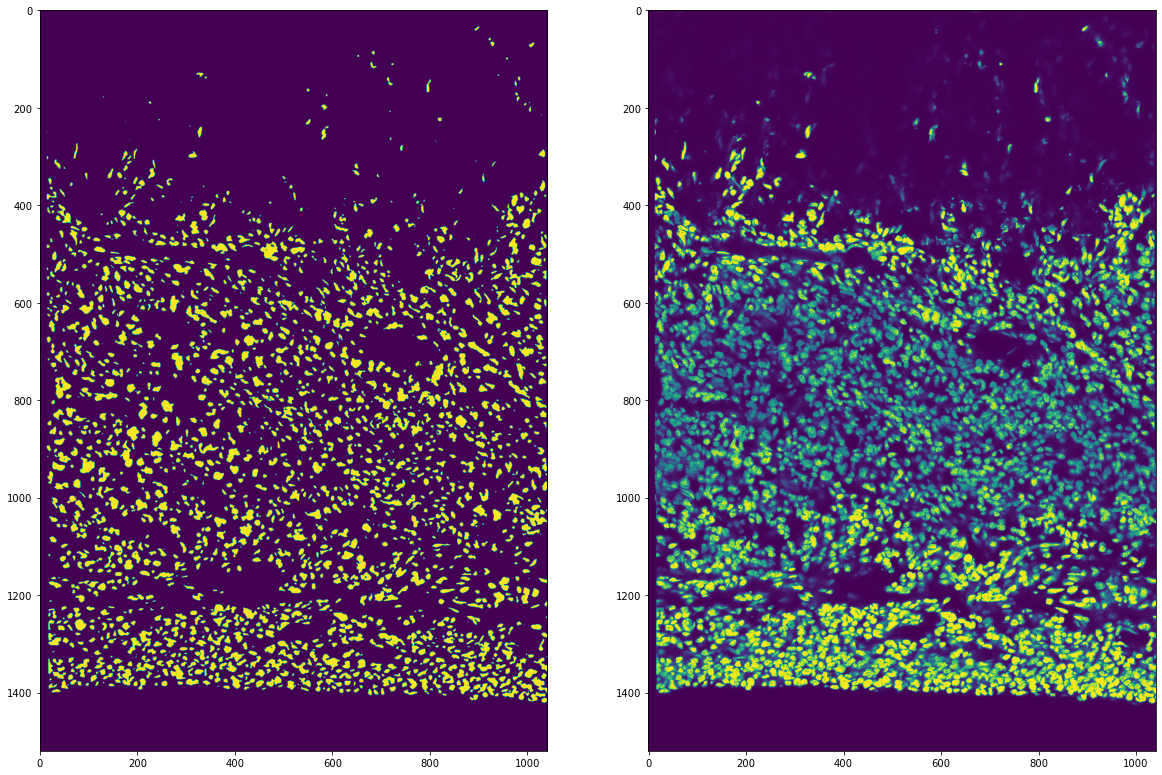

In [56]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(img)
mask.dtype

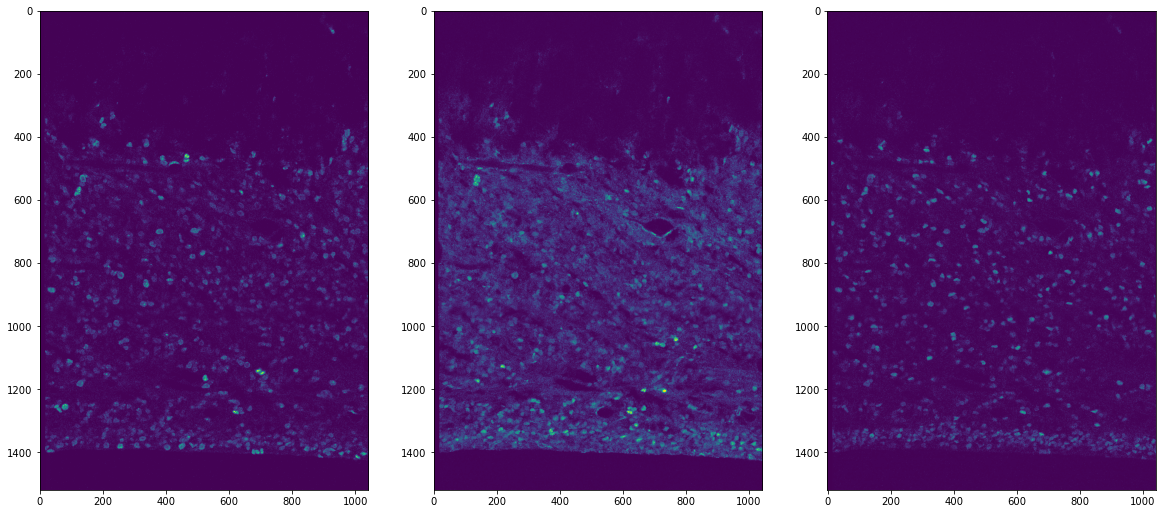

In [171]:
# Ki67 Tbr2 Pax6 Dapi
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
seek_image(img, c=0)
plt.imshow(img)
plt.subplot(1, 3, 2)
seek_image(img, c=1)
plt.imshow(img)
plt.subplot(1, 3, 3)
seek_image(img, c=2)
plt.imshow(img)

In [61]:
m = Image.fromarray(mask.astype(np.uint8) * 255)
m.save("/home/nathan/Desktop/data/immuno/RoiMaker/test_mask.png")
img.save("/home/nathan/Desktop/data/immuno/RoiMaker/test_dapi.png")

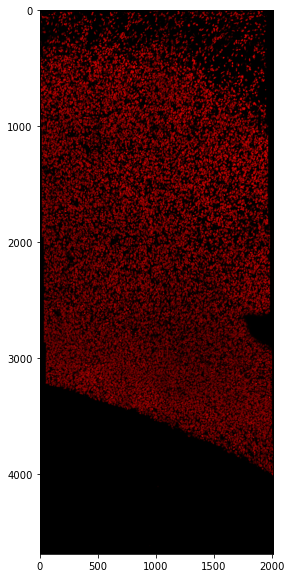

In [69]:
show(img2, c=3)

In [70]:
mask2 = segment_image(model, img2)

dtype('bool')

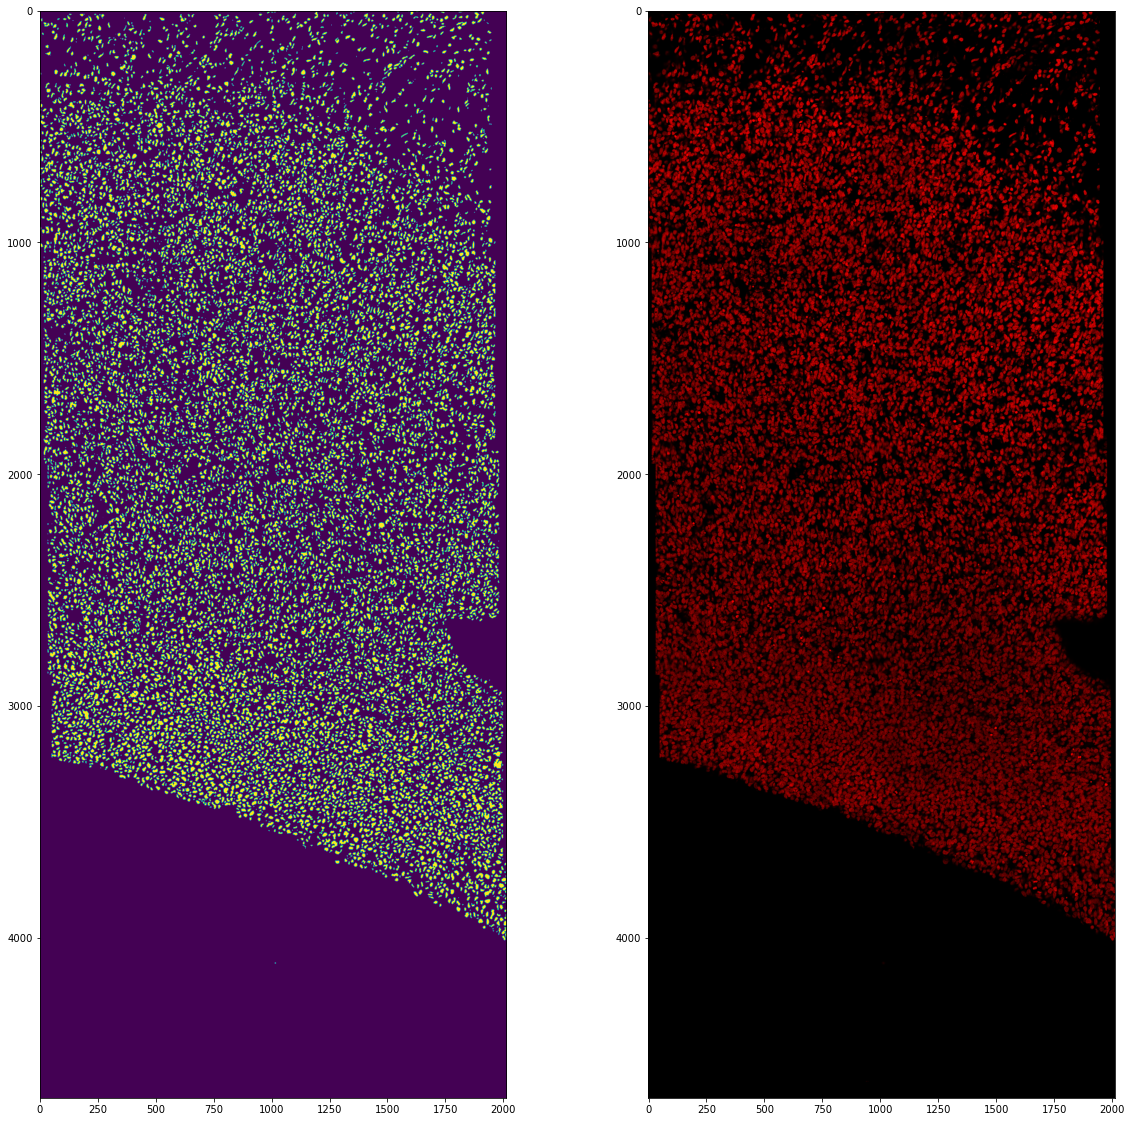

In [71]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(mask2)
plt.subplot(1, 2, 2)
plt.imshow(img2)
mask2.dtype

In [72]:
m2 = Image.fromarray(mask2.astype(np.uint8) * 255)
m2.save("/home/nathan/Desktop/data/immuno/RoiMaker/test_mask2.png")
img2.save("/home/nathan/Desktop/data/immuno/RoiMaker/test_dapi2.png")

## Commentary

We see that segmentation is not that bad.
Major default are : cells are very little but this is due to segmentation method, we consider using a dilate function, and mainly some cells are not well separated and are way too big.

This is ok for now as we just test the entire pipeline. However, model will have to be optimized later with these steps.

- Increase dataset size (-> 200 samples)
- Build a custom metric (IoU for individual connected components)
- Optimize augmentation using PBT
- Opimize GAN hyperparameters (batch size, optimizers for all 3 models etc)

Then if this does not improve performance enough, we can go further.

- Build a segmentation maps builder
- Build a GAN for sample generation from segmentation map
- Generate fake pairs image / segmentation map
- Train the model and this huge fake dataset

In [51]:
a = np.array([[[1, 2, 4], [1, 2, 3]]])
b = np.array([3, 4, 5])
a * b

array([[[ 3,  8, 20],
        [ 3,  8, 15]]])

In [57]:
np.unique(mask)

array([False,  True])

## ROI extraction

In [73]:
import cv2

In [94]:
nb_roi, conncomp = cv2.connectedComponents(mask.astype(np.uint8))

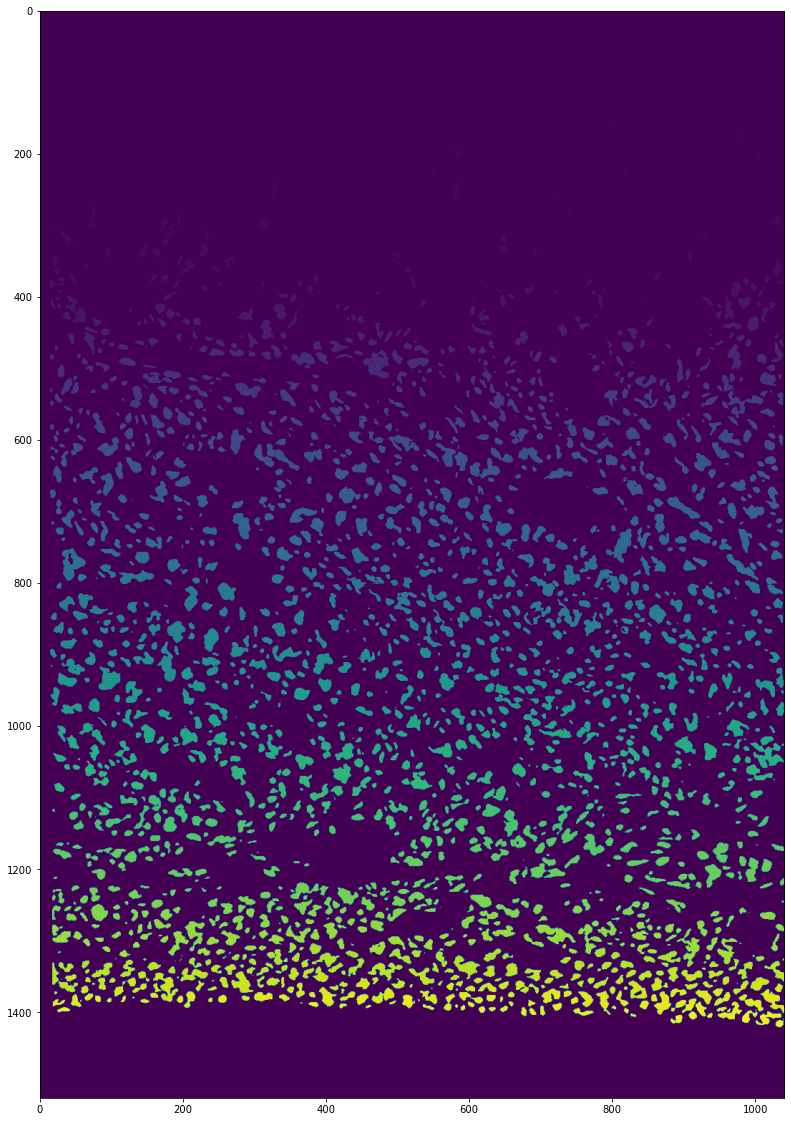

In [81]:
plt.figure(figsize=(20, 20))
plt.imshow(x)

In [106]:
from functools import cached_property 

class ROI:
    def __init__(self, mask, idx):
        self.mask = mask
        self.idx = idx
        self.dapi = None
        self.red = None
        self.green = None
        self.farred = None
    
    @cached_property
    def size(self):
        return np.sum(self.mask == self.idx)
    
    def intensity(self, image):
        return np.sum(image[self.mask == self.idx])
    
    def set_dapi(self, image):
        self.dapi = self.intensity(image)
    
    def set_green(self, image):
        self.green = self.intensity(image)
    
    def set_red(self, image):
        self.red = self.intensity(image)
    
    def set_farred(self, image):
        self.farred = self.intensity(image)

In [107]:
ls_roi = []

for i in range(1, nb_roi):
    ls_roi.append(ROI(conncomp, i))
    

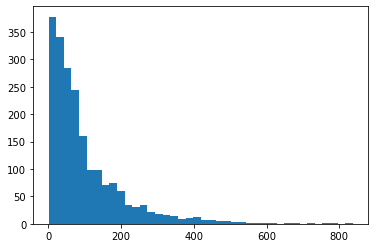

In [108]:
plt.hist([r.size for r in ls_roi], bins=40)
pass

In [109]:
# filter < 10 and > 400
ls_roi_filtsize = [r for r in ls_roi if r.size > 10 and r.size < 400]

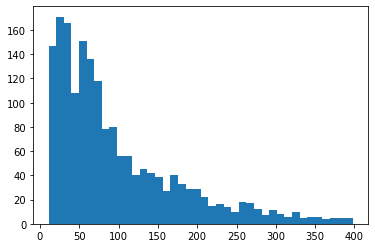

In [110]:
plt.hist([r.size for r in ls_roi_filtsize], bins=40)
pass

In [111]:
# Ki67 Tbr2 Pax6 Dapi

for r in ls_roi_filtsize:
    seek_image(img, c=0)
    r.set_green(np.asarray(img))
    seek_image(img, c=1)
    r.set_red(np.asarray(img))
    seek_image(img, c=2)
    r.set_farred(np.asarray(img))
    seek_image(img, c=3)
    r.set_dapi(np.asarray(img))

In [129]:
filt = lambda size: size > 40 and size < 350
filt_dapi = lambda dapi: dapi > 10000

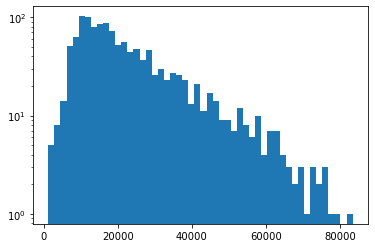

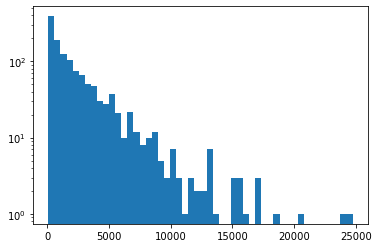

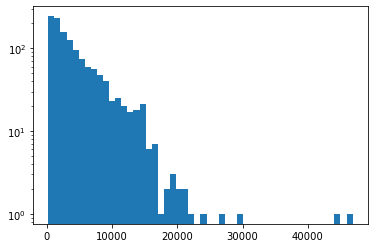

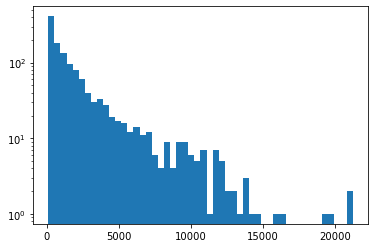

In [176]:
plt.hist([r.dapi for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.green for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.red for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.farred for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()

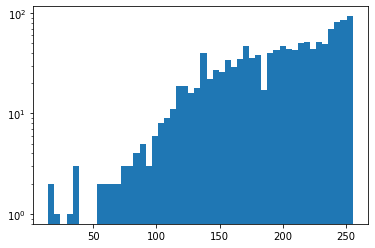

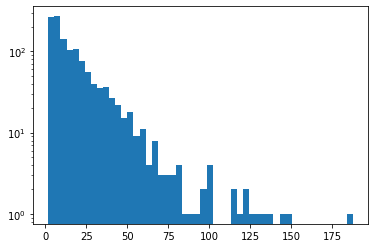

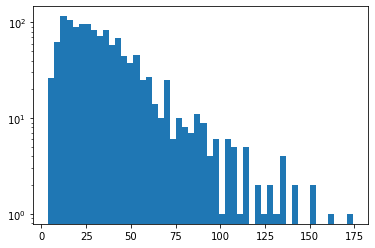

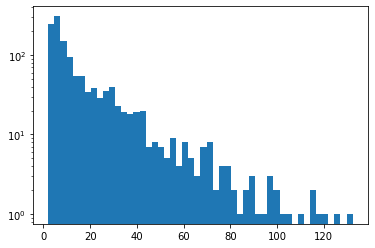

In [177]:
plt.hist([r.dapi / r.size for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.green / r.size for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.red / r.size for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.farred / r.size for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()

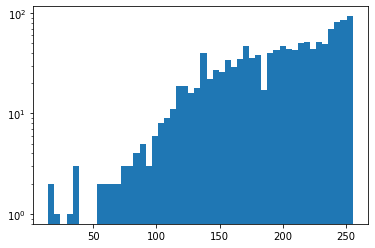

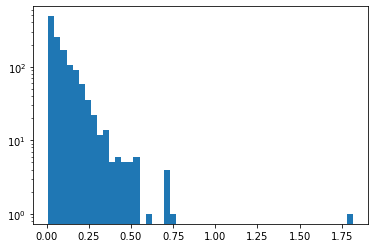

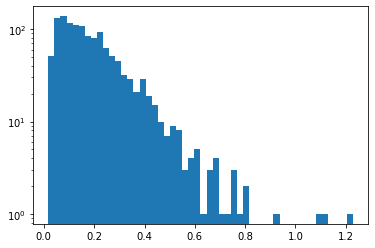

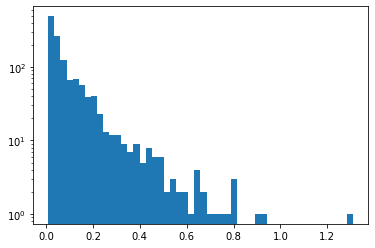

In [178]:
plt.hist([r.dapi / r.size for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.green / r.dapi for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.red / r.dapi for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([r.farred / r.dapi for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()

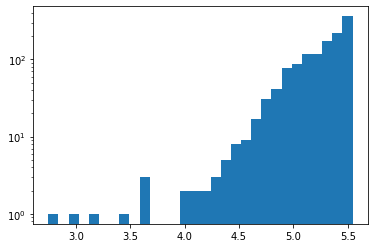

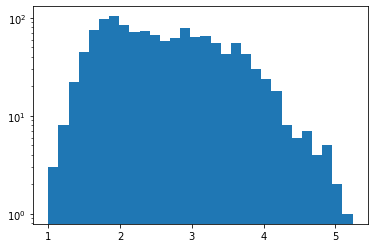

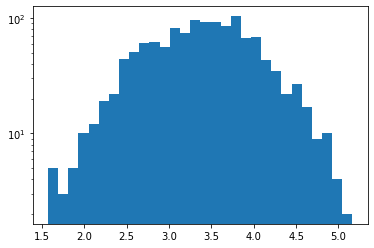

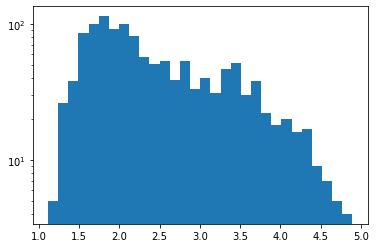

In [181]:
plt.hist([np.log(1 + r.dapi / r.size) for r in ls_roi_filtsize if filt(r.size)], bins=30, log=True)
plt.show()
plt.hist([np.log(1 + r.green / r.size) for r in ls_roi_filtsize if filt(r.size)], bins=30, log=True)
plt.show()
plt.hist([np.log(1 + r.red / r.size) for r in ls_roi_filtsize if filt(r.size)], bins=30, log=True)
plt.show()
plt.hist([np.log(1 + r.farred / r.size) for r in ls_roi_filtsize if filt(r.size)], bins=30, log=True)
plt.show()

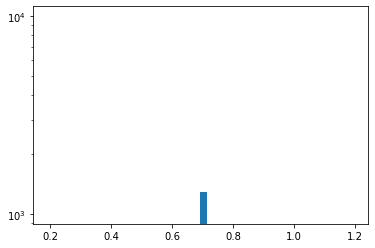

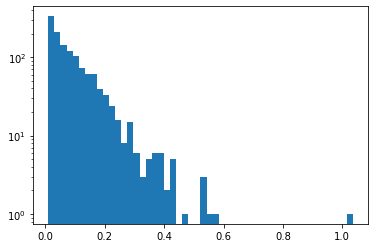

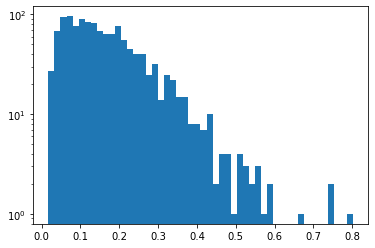

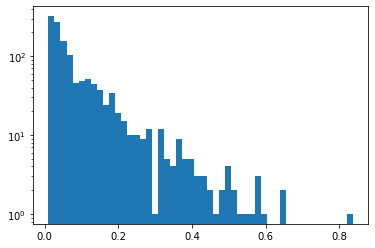

In [180]:
plt.hist([np.log(1 + r.dapi / r.dapi) for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([np.log(1 + r.green / r.dapi) for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([np.log(1 + r.red / r.dapi) for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()
plt.hist([np.log(1 + r.farred / r.dapi) for r in ls_roi_filtsize if filt(r.size)], bins=50, log=True)
plt.show()

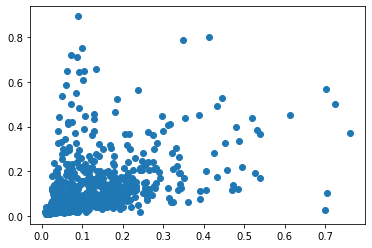

In [132]:
plt.scatter([r.green / r.dapi for r in ls_roi_filtsize if filt(r.size) and filt_dapi(r.dapi)],
            [r.farred / r.dapi for r in ls_roi_filtsize if filt(r.size) and filt_dapi(r.dapi)])

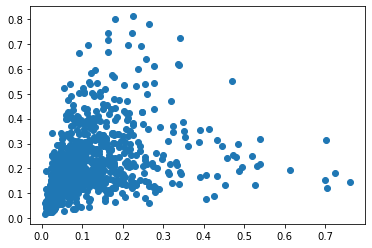

In [133]:
plt.scatter([r.green / r.dapi for r in ls_roi_filtsize if filt(r.size) and filt_dapi(r.dapi)],
            [r.red / r.dapi for r in ls_roi_filtsize if filt(r.size) and filt_dapi(r.dapi)])

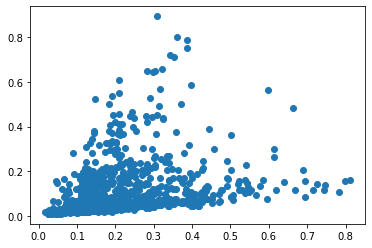

In [134]:
plt.scatter([r.red / r.dapi for r in ls_roi_filtsize if filt(r.size) and filt_dapi(r.dapi)],
            [r.farred / r.dapi for r in ls_roi_filtsize if filt(r.size) and filt_dapi(r.dapi)])

## Conclusion

We can see some relation between markers. However there is obviously a pollution between a canal and an other.  
This can be easily corrected with matrix inverse.

There is also some suspicions about bad cell quality sometimes that could make a lot of noise.
Therefore we need to individually check some cells (build a quick function for that), and maybe the best way to correct it is to look at inner variability for a marker.

Otherwise, piwel-wise correlation can also be somehow a good metric, but we lose the cell identity.

Now we must binarize some Tbr2+ cells and build a spatial network, then simulate distributions.

In [194]:
def plot_cell(image, roi, margin=20, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    # print stats
    # Ki67 Tbr2 Pax6 Dapi
    print("Id: %d, dapi: %f, tbr2: %f, pax6: %f, ki67: %f" %
         (roi.idx, roi.dapi, roi.red, roi.farred, roi.green))
    # select zone of image
    reduced = roi.mask == roi.idx
    where = np.array(np.where(reduced))

    x1, y1 = np.amin(where, axis=1)
    x2, y2 = np.amax(where, axis=1)
    # print(x1, y1, x2, y2)
    
    x1, y1 = max(0, x1 - margin), max(0, y1 - margin)
    x2, y2 = x2 + margin, y2 + margin
    # sub_image = image[x1:x2, y1:y2]
    plt.subplot(2, 3, 1)
    seek_image(image, c=0)
    plt.title("Ki67")
    plt.imshow(np.asarray(image)[x1:x2, y1:y2], vmin=0, vmax=255)
    
    plt.subplot(2, 3, 2)
    seek_image(image, c=1)
    plt.title("Tbr2")
    plt.imshow(np.asarray(image)[x1:x2, y1:y2], vmin=0, vmax=255)
    
    plt.subplot(2, 3, 3)
    seek_image(image, c=2)
    plt.title("Pax6")
    plt.imshow(np.asarray(image)[x1:x2, y1:y2], vmin=0, vmax=255)
    
    plt.subplot(2, 3, 4)
    seek_image(image, c=3)
    plt.title("DAPI")
    plt.imshow(np.asarray(image)[x1:x2, y1:y2], vmin=0, vmax=255)
    
    plt.subplot(2, 3, 5)
    plt.title("mask")
    plt.imshow(reduced[x1:x2, y1:y2])

In [161]:
len(ls_roi_filtsize)

1793

Id: 1721, dapi: 41988.000000, tbr2: 9172.000000, pax6: 1861.000000, ki67: 2336.000000


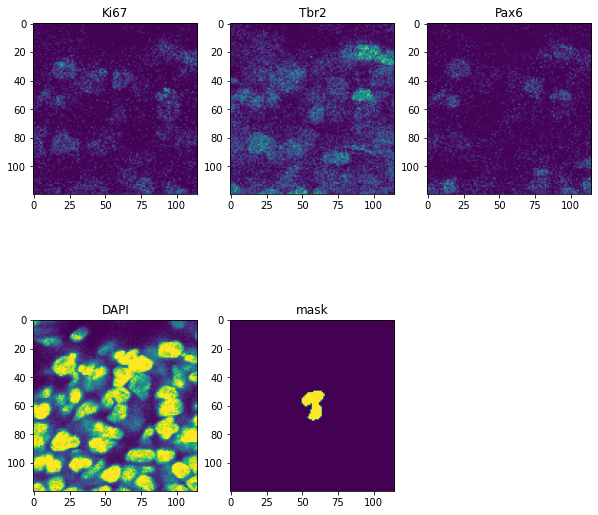

In [195]:
plot_cell(img, ls_roi_filtsize[1502], margin=50)

We normalized by dapi intensity but it is not good as sometime dapi is really intense. We suggest normalizing by nucleus size instead.

In [183]:
# define positivity and negativity
ls_roi_pos = [r for r in ls_roi_filtsize if np.log(1 + r.farred / r.size) > 3]
ls_roi_neg = [r for r in ls_roi_filtsize if np.log(1 + r.farred / r.size) < 3]

Id: 1699, dapi: 17350.000000, tbr2: 5206.000000, pax6: 4530.000000, ki67: 1679.000000
Id: 1983, dapi: 61386.000000, tbr2: 6751.000000, pax6: 5242.000000, ki67: 8480.000000


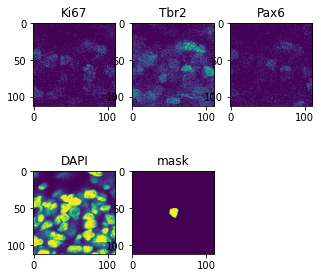

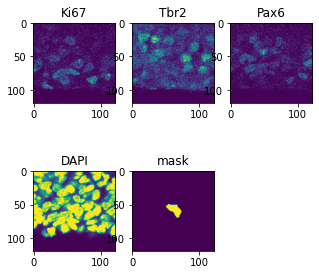

In [197]:
plot_cell(img, ls_roi_pos[300], margin=50, figsize=(5, 5))
plot_cell(img, ls_roi_pos[400], margin=50, figsize=(5, 5))

Id: 435, dapi: 28543.000000, tbr2: 2767.000000, pax6: 1049.000000, ki67: 2004.000000
Id: 586, dapi: 2678.000000, tbr2: 894.000000, pax6: 315.000000, ki67: 377.000000


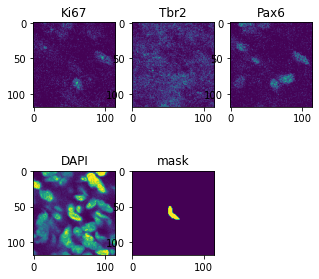

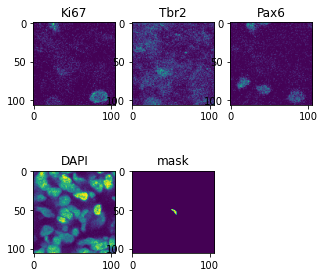

In [198]:
plot_cell(img, ls_roi_neg[300], margin=50, figsize=(5, 5))
plot_cell(img, ls_roi_neg[400], margin=50, figsize=(5, 5))

In [213]:
# plot mask of positive and mask of negative cells
# function np.in1d(arr, list)

id_pos = [r.idx for r in ls_roi_pos]
id_neg = [r.idx for r in ls_roi_neg]

mask_pos = np.in1d(conncomp, id_pos)
mask_neg = np.in1d(conncomp, id_neg)

mask_all = mask_pos.astype(np.int) * 1 + mask_neg.astype(np.int) * 2
len(id_pos), len(id_neg)

(423, 1370)

In [202]:
conncomp.shape, mask_all.shape

((1520, 1041), (1582320,))

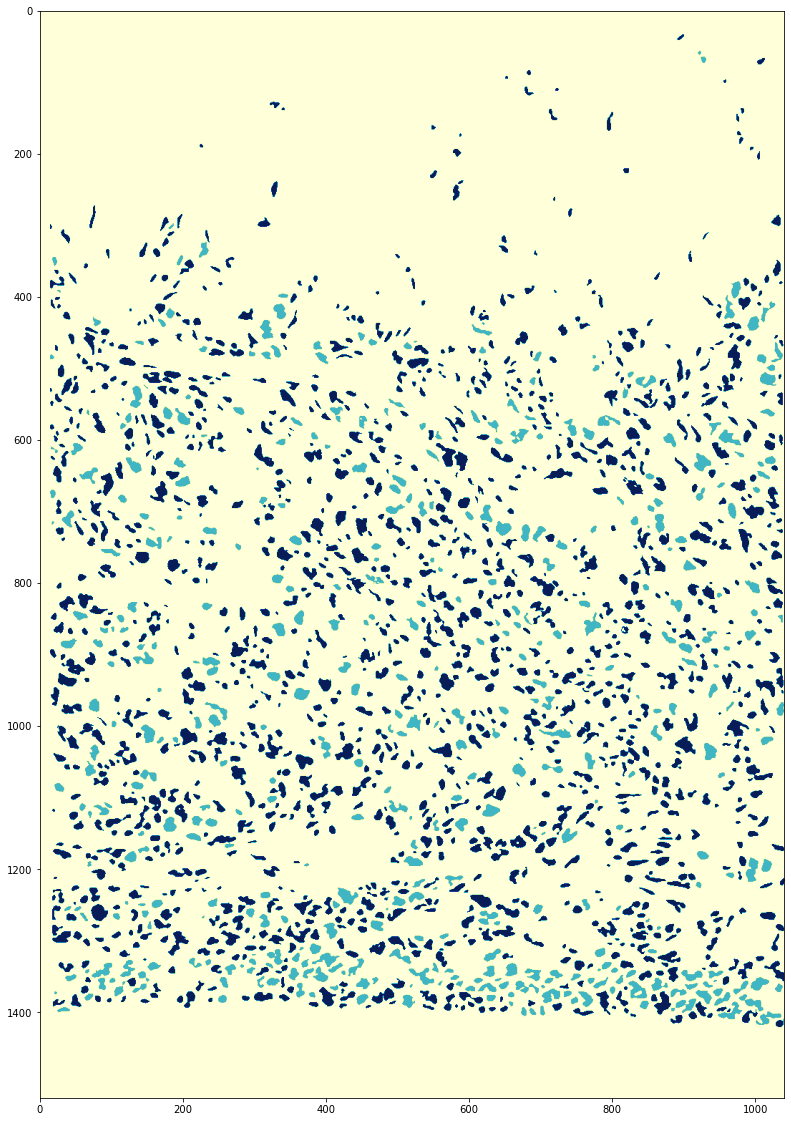

In [207]:
plt.figure(figsize=(20, 20))
plt.imshow(mask_all.reshape(conncomp.shape), cmap='YlGnBu')

We shall remove VZ as there are many Pax6 cells, also top layer which is too sparse

In [221]:
def filter_y(roi, min_y=0, max_y = 1e6):
    reduced = roi.mask == roi.idx
    where = np.array(np.where(reduced))

    y1, _ = np.amin(where, axis=1)
    y2, _ = np.amax(where, axis=1)
    return y1 > min_y and y2 < max_y

my_filter_y = lambda r: filter_y(r, min_y=400, max_y=1300)

In [222]:
ls_filt_pos = filter(my_filter_y, ls_roi_pos)
ls_filt_neg = filter(my_filter_y, ls_roi_neg)

In [439]:
my_filter_y_vz = lambda r: filter_y(r, min_y=1300, max_y=1e9)
ls_vz_pos = filter(my_filter_y_vz, ls_roi_pos)
ls_vz_neg = filter(my_filter_y_vz, ls_roi_neg)

id_vz_neg = [r.idx for r in ls_vz_neg]
id_vz_pos = [r.idx for r in ls_vz_pos]
mask_vz_pos = np.in1d(conncomp, id_vz_pos)
mask_vz_neg = np.in1d(conncomp, id_vz_neg)

mask_vz_all = mask_vz_pos.astype(np.int) * 1 + mask_vz_neg.astype(np.int) * 2

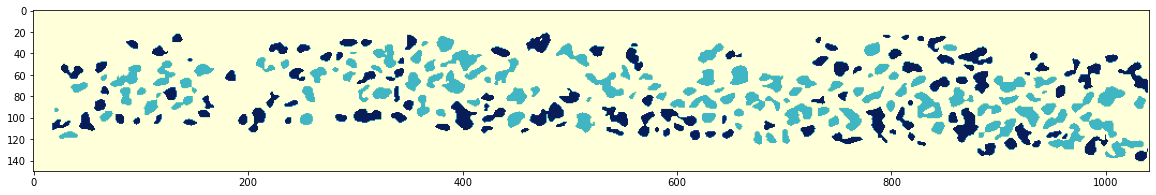

In [467]:
plt.figure(figsize=(20, 20))
plt.imshow(mask_vz_all.reshape(conncomp.shape)[1280:1430], cmap='YlGnBu')

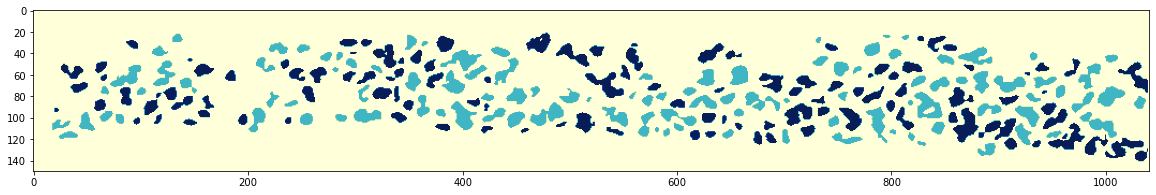

In [496]:
import random
# randomize
def randomize(pos, neg):
    p_len = len(pos)
    all_ = pos + neg
    random.shuffle(all_)
    return all_[:p_len], all_[p_len:]

rand_posvz, rand_negvz = randomize(id_vz_pos, id_vz_neg)

mask_r_posvz = np.in1d(conncomp, rand_posvz)
mask_r_negvz = np.in1d(conncomp, rand_negvz)

mask_r_allvz = mask_r_posvz.astype(np.int) * 1 + mask_r_negvz.astype(np.int) * 2
len(rand_posvz), len(rand_negvz)

plt.figure(figsize=(20, 20))
plt.imshow(mask_r_allvz.reshape(conncomp.shape)[1280:1430], cmap='YlGnBu')

In [223]:
# plot mask of positive and mask of negative cells
# function np.in1d(arr, list)

id_f_pos = [r.idx for r in ls_filt_pos]
id_f_neg = [r.idx for r in ls_filt_neg]

mask_f_pos = np.in1d(conncomp, id_f_pos)
mask_f_neg = np.in1d(conncomp, id_f_neg)

mask_f_all = mask_f_pos.astype(np.int) * 1 + mask_f_neg.astype(np.int) * 2
len(id_f_pos), len(id_f_neg)

(306, 1155)

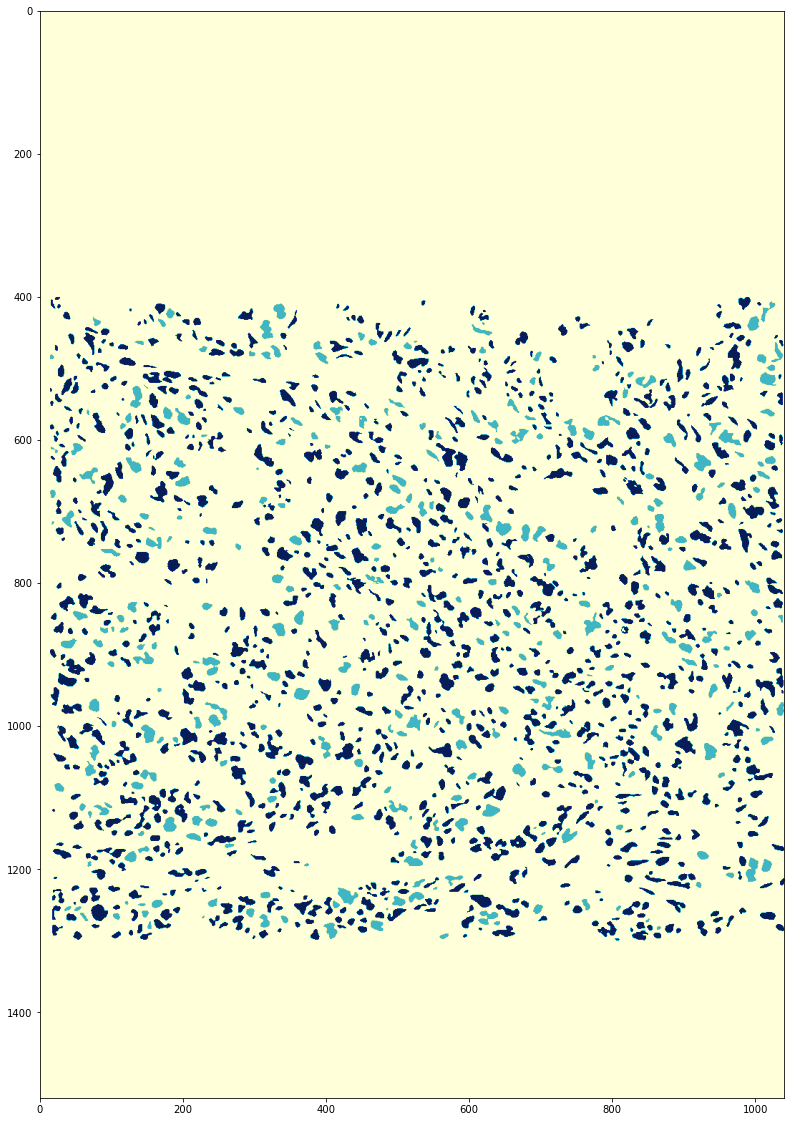

In [224]:
plt.figure(figsize=(20, 20))
plt.imshow(mask_f_all.reshape(conncomp.shape), cmap='YlGnBu')

In [225]:
import random
# randomize
def randomize(pos, neg):
    p_len = len(pos)
    all_ = pos + neg
    random.shuffle(all_)
    return all_[:p_len], all_[p_len:]

rand_pos, rand_neg = randomize(id_f_pos, id_f_neg)

mask_r_pos = np.in1d(conncomp, rand_pos)
mask_r_neg = np.in1d(conncomp, rand_neg)

mask_r_all = mask_r_pos.astype(np.int) * 1 + mask_r_neg.astype(np.int) * 2
len(rand_pos), len(rand_neg)

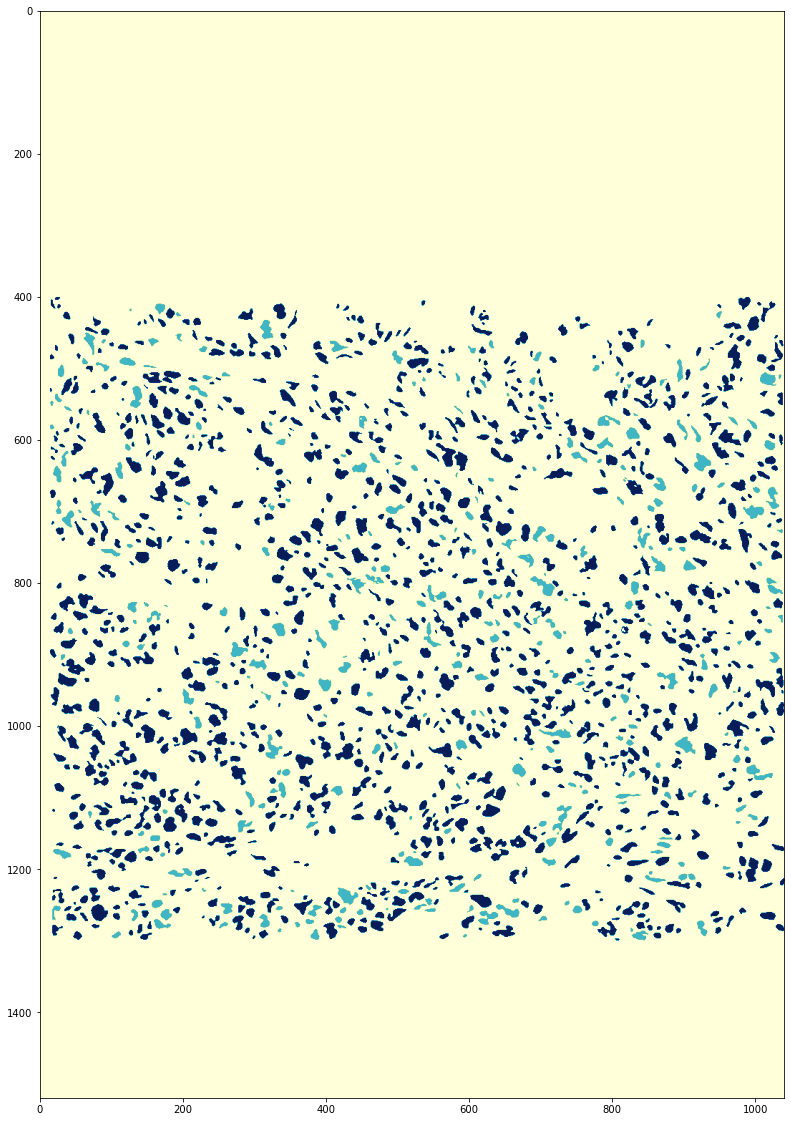

In [228]:
plt.figure(figsize=(20, 20))
plt.imshow(mask_r_all.reshape(conncomp.shape), cmap='YlGnBu')

# Metric

We define the beginning of the metric :
- Get gravity center
- Run k-nn (k = 3-5)
- Build graph
- Get shortest path to + or to opposite
- Make an histogram
- Analyze

In [246]:
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage import label

def center(conncomp, idx):
    return center_of_mass(conncomp == idx)

In [247]:
center(conncomp, 4), center(conncomp, 3)

((71.109375, 1006.9375), (68.62962962962963, 926.7037037037037))

In [249]:
# build dataset
dts = list()

for idx in id_f_pos:
    gravity = center(conncomp, idx)
    dts.append((gravity, 1))
    
for idx in id_f_neg:
    gravity = center(conncomp, idx)
    dts.append((gravity, 0))
    
X = np.array([x[0] for x in dts])
y = np.array([x[1] for x in dts])

In [444]:
# build dataset
dts_vz = list()

for idx in id_vz_pos:
    gravity = center(conncomp, idx)
    dts_vz.append((gravity, 1))
    
for idx in id_vz_neg:
    gravity = center(conncomp, idx)
    dts_vz.append((gravity, 0))
    
Xvz = np.array([x[0] for x in dts_vz])
yvz = np.array([x[1] for x in dts_vz])

In [270]:
X, y, len(X)

(array([[ 419.928, 1015.311],
        [ 420.26 ,  334.952],
        [ 423.607,  181.549],
        ...,
        [1292.905,  593.476],
        [1294.867,  298.467],
        [1297.875,  806.125]]),
 array([1, 1, 1, ..., 0, 0, 0]),
 1461)

In [262]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=3+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
distances = distances[:, 1:]
indices = indices[:, 1:]

In [263]:
indices

array([[ 310,    3,  307],
       [ 319,    6,  350],
       [ 323,  312,    5],
       ...,
       [1419, 1447,  305],
       [1445, 1451,  296],
       [1430, 1448, 1427]])

In [265]:
import networkx as nx
G = nx.Graph()

In [267]:
for i, ngb in enumerate(indices):
    for n in ngb:
        G.add_edge(i, n)

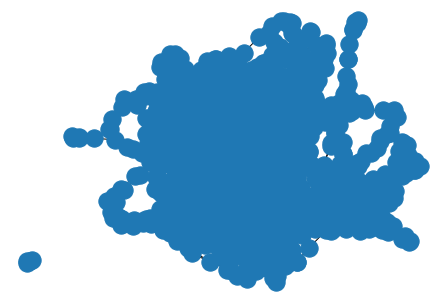

In [269]:
nx.draw(G)

In [281]:
Gc_nodes = max(nx.connected_components(G), key=len)
Gc = G.subgraph(Gc_nodes)

In [287]:
def dist_from_pos(G, node, labels):
    for i in range(10):
        Gsub = nx.ego_graph(G, node, radius=i)
        for n in Gsub.nodes:
            if labels[n] == 1:
                return i
    return 10

dist_from_pos(Gc, 1000, y)

2

In [356]:
G[1000]

AtlasView({963: {}, 990: {}, 1015: {}, 1011: {}})

In [357]:
def segregation(G, node, labels):
    total = len(G[node])
    score = 0
    
    for n in G[node]:
        if labels[n] == labels[node]:
            score += 1
    
    return score / total

segregation(Gc, 1000, y)

1.000

(array([306.,   0., 650.,   0., 363.,   0., 113.,   0.,  22.,   3.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

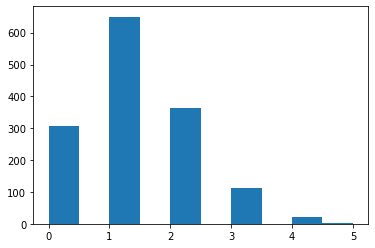

In [288]:
plt.hist([dist_from_pos(Gc, i, y) for i in Gc.nodes])

In [418]:
def list_distances(X, y, k=3):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = distances[:, 1:]
    indices = indices[:, 1:]
    G = nx.Graph()
    for i, ngb in enumerate(indices):
        for n in ngb:
            G.add_edge(i, n)

    Gc_nodes = max(nx.connected_components(G), key=len)
    Gc = G.subgraph(Gc_nodes)
    
    return [dist_from_pos(Gc, i, y) for i in Gc.nodes]

In [419]:
def list_segregations(X, y, k=3):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = distances[:, 1:]
    indices = indices[:, 1:]
    G = nx.Graph()
    for i, ngb in enumerate(indices):
        for n in ngb:
            G.add_edge(i, n)
            
    Gc_nodes = max(nx.connected_components(G), key=len)
    Gc = G.subgraph(Gc_nodes)
    
    return [segregation(Gc, i, y) for i in Gc.nodes]

(array([306., 650., 363., 113.,  22.,   3.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

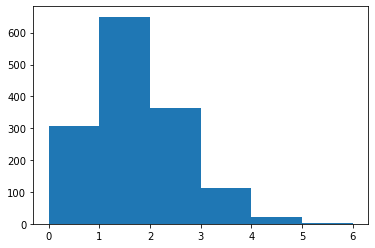

In [424]:
ls1 = list_distances(X, y)
plt.hist(ls1, bins=[0, 1, 2, 3, 4, 5, 6])

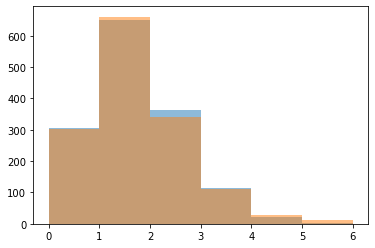

(array([ 304.,  965., 1307., 1418., 1445., 1457.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

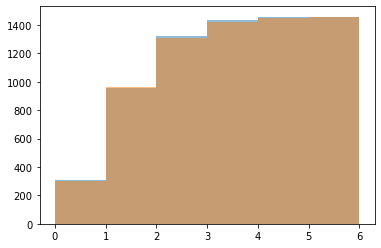

In [429]:
y2 = y.copy()
np.random.shuffle(y2)
ls2 = list_distances(X, y2)
plt.hist(ls1, alpha=0.5, bins=[0, 1, 2, 3, 4, 5, 6])
plt.hist(ls2, alpha=0.5, bins=[0, 1, 2, 3, 4, 5, 6])
plt.show()
plt.hist(ls1, alpha=0.5, bins=[0, 1, 2, 3, 4, 5, 6], cumulative=True)
plt.hist(ls2, alpha=0.5, bins=[0, 1, 2, 3, 4, 5, 6], cumulative=True)

(array([142.,   4.,  75., 118.,   6., 119., 249., 183.,  58., 503.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

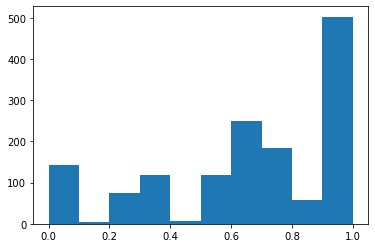

In [430]:
ls1 = list_segregations(X, y)
plt.hist(ls1)#, bins=[0, 1, 2, 3, 4, 5, 6])

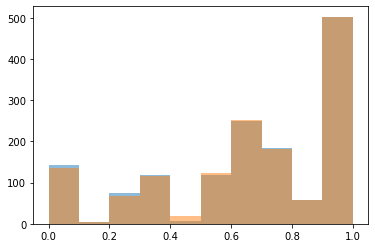

(array([ 135.,  139.,  206.,  322.,  340.,  464.,  716.,  897.,  954.,
        1457.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

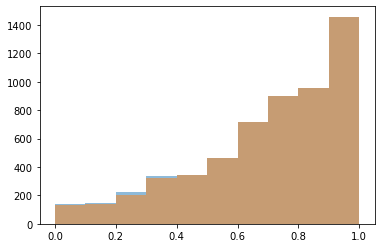

In [431]:
y2 = y.copy()
np.random.shuffle(y2)
ls2 = list_segregations(X, y2)
plt.hist(ls1, alpha=0.5)
plt.hist(ls2, alpha=0.5)
plt.show()
plt.hist(ls1, alpha=0.5, cumulative=True)
plt.hist(ls2, alpha=0.5, cumulative=True)

In [432]:
y2 = y.copy()
np.random.shuffle(y2)
ls1 = list_segregations(X, y)
ls2 = list_segregations(X, y2)

print(np.round(np.mean(ls1), 7))
print(np.round(np.mean(ls2), 7))
alls = list()

for i in range(100):
    np.random.shuffle(y2)
    ls2 = list_segregations(X, y2)
    alls.append(np.mean(ls2))

print(np.mean(alls), np.std(alls))

0.670368
0.6704971
0.6691406510442199 0.006509562733616894


In [433]:
y2 = y.copy()
np.random.shuffle(y2)
ls1 = list_segregations(X, y, k=5)
ls2 = list_segregations(X, y2, k=5)

print(np.round(np.mean(ls1), 7))
print(np.round(np.mean(ls2), 7))
alls = list()

for i in range(100):
    np.random.shuffle(y2)
    ls2 = list_segregations(X, y2)
    alls.append(np.mean(ls2))

print(np.mean(alls), np.std(alls))

0.6652694
0.6696813
0.6686448181194234 0.006455674642990543


In [509]:
y2 = y.copy()
np.random.shuffle(y2)
ls1 = list_segregations(X, y, k=3)
ls2 = list_segregations(X, y2, k=3)

print(np.round(np.mean(ls1), 7))
print(np.round(np.mean(ls2), 7))
alls = list()

for i in range(100):
    np.random.shuffle(y2)
    ls2 = list_segregations(X, y2, k=3)
    alls.append(np.mean(ls2))

print(np.mean(alls), np.std(alls))

0.670368
0.6754224
0.667399679707161 0.006515644844472364


In [498]:
k = 3

yvz2 = yvz.copy()
np.random.shuffle(yvz2)
ls1 = list_segregations(Xvz, yvz, k=k)
ls2 = list_segregations(Xvz, yvz2, k=k)

print(np.round(np.mean(ls1), 7))
print(np.round(np.mean(ls2), 7))
alls = list()

for i in range(100):
    np.random.shuffle(yvz2)
    ls2 = list_segregations(Xvz, yvz2, k=k)
    alls.append(np.mean(ls2))

print(np.mean(alls), np.std(alls))

0.5527397
0.4996956
0.4930532724505327 0.024389945711295824


In [503]:
k = 3

yvz2 = yvz.copy()
np.random.shuffle(yvz2)
ls1 = list_distances(Xvz, yvz, k=k)
ls2 = list_distances(Xvz, yvz2, k=k)

print(np.round(np.mean(ls1), 7))
print(np.round(np.mean(ls2), 7))
alls = list()

for i in range(100):
    np.random.shuffle(yvz2)
    ls2 = list_distances(Xvz, yvz2, k=k)
    alls.append(np.mean(ls2))

print(np.mean(alls), np.std(alls))

0.6027397
0.5525114
0.5660273972602741 0.0203790112922323


In [507]:
k = 3

yvz2 = yvz.copy()
np.random.shuffle(yvz2)
ls1a = list_distances(Xvz, yvz, k=k)
ls1b = list_segregations(Xvz, yvz, k=k)

print(np.mean([ls1a, ls1b]))
alls = list()

for i in range(100):
    np.random.shuffle(yvz2)
    ls2a = list_distances(Xvz, yvz2, k=k)
    ls2b = list_segregations(Xvz, yvz2, k=k)
    alls.append(np.mean([ls2a, ls2b]))

print(np.mean(alls), np.std(alls))

0.5777397260273973
0.5309615677321157 0.021440695641920627


# Conclusion

Dispersion of Pax6 in the progenitors seems completely RANDOM !

In [ ]:
"""
















"""